# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Hedi fendri , Didier Negretto <br> 
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

In this part of the TP we will apply different image analysis algorithms to be able to calculate the surface a brain from a MRI of a human patient. This will be done using a region growing algorithm and two different conditions for labelling:

* **Thershold** in this case the pixel is labelled if it has a value which is higher than a given threshold. This is done by funtion `region_growing_thersholding`
* **Similarity** in this case the pixel is labelled if it has a value that do not differ more than 6 compared to a close labelled pixel. This is done by function `region_growing_similarity`

In a second moment countor detection is explored in two different ways:

* **Canny** in this case a Canny filter is applied to the image. This, unfortunately gives open contours. To fix this issue closing or dilution are performed. In a second time two way of calculating the surface are used:
    * **Area** In this case the area is computed using only the contour, this as the issu that internal missing parts are considered as part of the brain even if this is not correct.
    * **Region Growing** In this case region growing is applied to compute the surface inside the countour. This allow us to neglect internal parts and so we can get a better approximation of the brain surface.

### 1.1 Brain image visualization

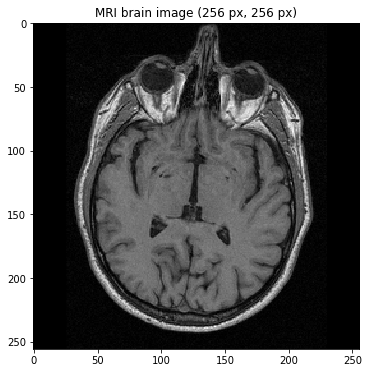

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage import sobel
import cv2
from skimage import feature
from skimage import measure
import scipy.ndimage as nd
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))

plt.show()

### 1.2 Region growing

To be able to correctly set a threshold value the histogram of the image is plotted and the thershold is chosen based on that

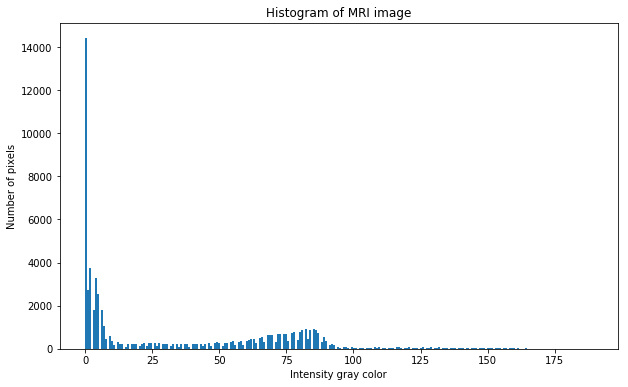

In [3]:
plt.figure(figsize=(10,6))
plt.hist(brain_im.ravel(),bins=256)
plt.xlabel("Intensity gray color")
plt.ylabel("Number of pixels")
plt.title("Histogram of MRI image")
plt.show()

From the figure above we can deduce that $THRESHOLD=70$ is an aprropriate value for the threshold 

#### Region growing Method 

Here the region growing funciton is defined and the similarity criterion is applied

In [4]:
def region_growing_similarity(img,seed,sim): 
    """"
    This function performs region growing by using similarity to label the pixels
    If the pixel value is within +/- sim compared to value of the neighbour then it is labelled as part of the brain
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        img : The array that contains the image
        seed: The posiion of a pixel inside the brain
        sim: Simalarity criterion for labelling
    -------------------------------------------------------------------------------------------------------
    return : 
        Image with labelled brain.
    """ 
    #define neighbours 
    neigh = [(1,1), (-1,0), (0,1), (1,0), (-1,1), (0,-1), (-1,-1), (1,-1)]
    height=img.shape[0]
    weight=img.shape[1] 
    growingImg=np.zeros_like(img,dtype=int)
    visitedPixels=seed
    while visitedPixels: 
        (current_x , current_y)=visitedPixels.pop() 
        growingImg[current_x,current_y]=1
        
        for neigh_x,neigh_y in neigh: 
            if (current_x+neigh_x >=0) and (current_x+neigh_x<height) and (current_y+neigh_y >=0) and (current_y+neigh_y<weight) and ( growingImg[current_x+neigh_x,current_y+neigh_y]==0) and (img[current_x+neigh_x,current_y+neigh_y]<256) and (np.abs(int(img[current_x+neigh_x,current_y+neigh_y])-int(img[current_x,current_y]))<=sim): 
                visitedPixels.append((current_x+neigh_x,current_y+neigh_y))
    return growingImg 
    

Here the function using region growing and thersholding

In [5]:
def region_growing_thersholding(img,seed,tresh):
    """"
    This function performs region growing by using a threshold to label the pixels
    If the pixel value is higher than tresh and it is close to a labelled pixel thenit is labeled as well
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        img : The array that contains the image
        seed: The posiion of a pixel inside the brain
        thersh: The value of the threshold
    -------------------------------------------------------------------------------------------------------
    return : 
        Image where brain is labelled
    """ 
    #define neighbours 
    neigh = [(1,1), (-1,0), (0,1), (1,0), (-1,1), (0,-1), (-1,-1), (1,-1)]
    height=img.shape[0]
    weight=img.shape[1] 
    growingImg=np.zeros_like(img,dtype=int)
    visitedPixels=seed
    while visitedPixels: 
        (current_x , current_y)=visitedPixels.pop() 
        growingImg[current_x,current_y]=1
        
        for neigh_x,neigh_y in neigh: 
            if (current_x+neigh_x >=0) and (current_x+neigh_x<height) and (current_y+neigh_y >=0) and (current_y+neigh_y<weight) and ( growingImg[current_x+neigh_x,current_y+neigh_y]==0) and (img[current_x+neigh_x,current_y+neigh_y]<256) and (img[current_x+neigh_x,current_y+neigh_y]>=tresh): 
                visitedPixels.append((current_x+neigh_x,current_y+neigh_y))
    return growingImg 

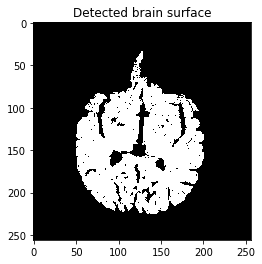

The brain size using the growing method with similarity is : 16264


In [6]:
seed=[(150,60)]
THRESHOLD = 70
SIMILARITY=5
growinhImg=region_growing_similarity(brain_im,seed,SIMILARITY)
plt.imshow(growinhImg,cmap='gray')
plt.title("Detected brain surface")
plt.show()

brain_size_growing=np.sum(growinhImg)
print("The brain size using the growing method with similarity is :",brain_size_growing)

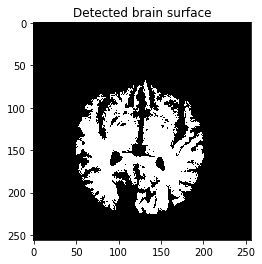

The brain size using the growing method with thersholding is : 12063


In [7]:
seed=[(150,60)]
THRESHOLD = 70
growinhImg=region_growing_thersholding(brain_im,seed,THRESHOLD)
plt.imshow(growinhImg,cmap='gray')
plt.title("Detected brain surface")
plt.show()

brain_size_growing=np.sum(growinhImg)
print("The brain size using the growing method with thersholding is :",brain_size_growing)

Region growing can correctly compute the surface of the brain if the parameters are well tuned and the seed is chosen in a appropriate position. By comparing the similarity condition and the threshold we can say that the former is well performing and it can detect a bigger surface (by including the borders), while the latter is better for detecing the edges of the brain.

### 1.3 Contour detection
Now we can consider contour detection 

In [8]:
import cv2 
from skimage import feature, measure

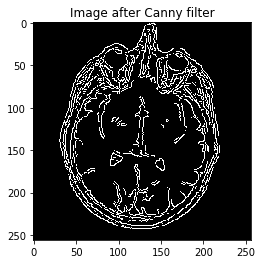

In [9]:
canny=cv2.Canny(brain_im, 100,200)
plt.title("Image after Canny filter")
plt.imshow(canny,cmap='gray')

As we can see in the figure above, the contours that are detected are open, thus the surface can't be computed. Solution to this is to a morphological transformation such as closing, which preserves the surface. Another approach could be to use dilution, but this would increase the border's linewidth, thus modifying the result.

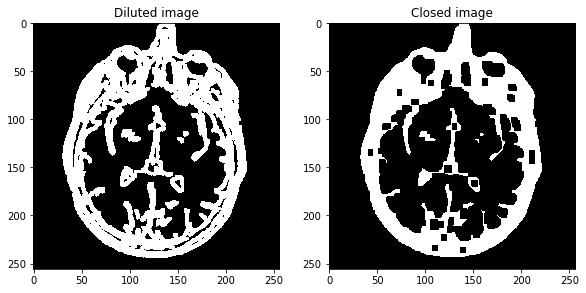

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
countour_dilated =cv2.dilate(canny, kernel)
kernel = np.ones((6,6))
countour_closed  = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel )
fig= plt.figure(figsize=((15,15)))
ax=fig.add_subplot(2,3,1)
ax.set_title("Diluted image")
ax.imshow(countour_dilated,cmap='gray')

ax=fig.add_subplot(2,3,2)
ax.set_title("Closed image")
ax.imshow(countour_closed,cmap='gray')


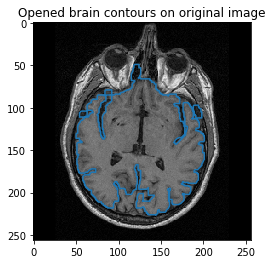

The brain size using the contour detection and closing is=  16900.0


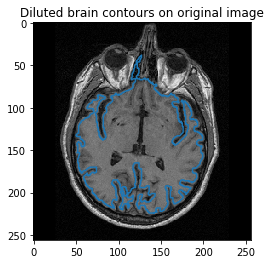

The brain size using the contour detection and dilution is=  15062.5


In [11]:
contours_detection = measure.find_contours(countour_closed,10)
contours_list = []
for i in contours_detection:
    contours_list.append(len(i))
contour_sorted =np.sort(np.copy(contours_list))
index_last = contours_list.index(contour_sorted[-1])
brain_contour = contours_detection[index_last]
brain_contour = brain_contour.astype(int)
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap='gray')
ax.plot(brain_contour[:, 1], brain_contour[:, 0], linewidth=1.5)
ax.axis('image')
ax.set_title('Opened brain contours on original image')
plt.show()
brain_size=cv2.contourArea(brain_contour)
print("The brain size using the contour detection and closing is= ",brain_size)

contours_detection = measure.find_contours(countour_dilated,10)
contours_list = []
for i in contours_detection:
    contours_list.append(len(i))
contour_sorted =np.sort(np.copy(contours_list))
index_last = contours_list.index(contour_sorted[-1])
brain_contour = contours_detection[index_last]
brain_contour = brain_contour.astype(int)
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap='gray')
ax.plot(brain_contour[:, 1], brain_contour[:, 0], linewidth=1.5)
ax.axis('image')
ax.set_title('Diluted brain contours on original image')
plt.show()
brain_size=cv2.contourArea(brain_contour)
print("The brain size using the contour detection and dilution is= ",brain_size)

As a second method for computing the surface using countour detection is region growing. In this case the seed is placed inside the contour and region growing is applied. The advantage of such a method is that we can exclude from the surface the internal less dense zones that are not part of the brain. Thus improving our approximation.

In [12]:
def binary_region_growing(img,th): 
    """"
    This function performs binary region growing (only for images where a contour is drawn)
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        img : The array that contains the image
        th: Threshold to detect contour and avoid internal objects
    -------------------------------------------------------------------------------------------------------
    return : 
        Image with labelled brain.
    """ 
    
    #define neighbours 
    neigh = [(1,1), (-1,0), (0,1), (1,0), (-1,1), (0,-1), (-1,-1), (1,-1)]
    height=img.shape[0]
    weight=img.shape[1] 
    growingImg=np.zeros_like(img,dtype=int)
    visitedPixels=[(121,120)]
    while visitedPixels: 
        (current_x , current_y)=visitedPixels.pop() 
        growingImg[current_x,current_y]=1
        
        for neigh_x,neigh_y in neigh: 
            if (current_x+neigh_x >=0) and (current_x+neigh_x<height) and (current_y+neigh_y >=0) and (current_y+neigh_y<weight) and ( growingImg[current_x+neigh_x,current_y+neigh_y]==0) and (img[current_x+neigh_x,current_y+neigh_y]<256) and (np.abs(int(img[current_x+neigh_x,current_y+neigh_y])-int(img[current_x,current_y]))<=th): 
                visitedPixels.append((current_x+neigh_x,current_y+neigh_y))
    return growingImg 
    

The brain size using the contour detection, dilution and region growing is=  13254
The brain size using the contour detection, closing and region growing is=  15762


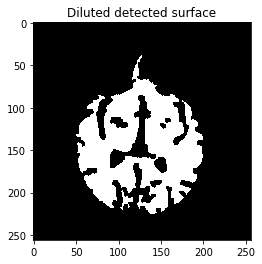

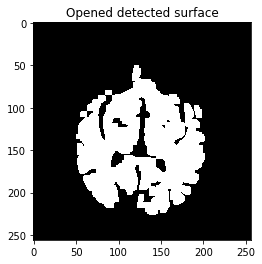

In [13]:
THRESHOLD=1 #Just verify that the pixels are inside the external contour and inside the internal one
imgS=binary_region_growing(countour_dilated,THRESHOLD)
plt.figure()
plt.title("Diluted detected surface")
plt.imshow(imgS, cmap = 'gray') 
brain_size=imgS.sum()
print("The brain size using the contour detection, dilution and region growing is= ",brain_size)

seed=[(150,60)]
THRESHOLD=1 #Just verify that the pixels are inside the external contour and inside the internal one
imgS=binary_region_growing(countour_closed,THRESHOLD)
plt.figure()
plt.title("Opened detected surface")
plt.imshow(imgS, cmap = 'gray') 
brain_size=imgS.sum()
print("The brain size using the contour detection, closing and region growing is= ",brain_size)

It is possible to notice that the diluted image gives a lower value for the surface of the brain. This is expecte because dilution  increases the linewidth of the contours, thus reducing the internal surface. 

#### Conclusion

In conclusion we can say that both contour detection and region growing can accurately compute the surface of the brain in a MRI image. The results obtained varies between: 16264 and 12063 depending on the techniques used. Contours detection have the advantage that the seed do not need to be chosen, while region growing do not need morphology, which prevents the modification of the results (like in the case of dilution).

On the other hand, contour detection can only compute the surface inside a closed contours, thus if there is a nested object it becomes more difficult to find. That's why, the two techniques have also been tested togheter.


### 1.4 Additional method(s)
#### Simple Thresholding 

In this part some other methods are tested:
* **Thersholding** in this case thresholding is performed, then opening to delete small noisy points around the brain. All the white pixels are then considered part of the brain.
* **Active Contours** in this case active contours is applied to an opened and threesholeded image. This gives a closed contour, the points are then labelled as part of the brain if their value is higher than a given treshold. This last part is done to discard dark regions inside the brain.

### Thershold


In [14]:
def simple_thresholding(img,th1,th2):
    """"
    This function threshold the input image
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        im : The array that contains the image
        th1: low threshold value used to threshold the image 
        th2: high threshold value used to threshold the image 
    -------------------------------------------------------------------------------------------------------
    return : 
        thresholded image as numpy array 
    """ 
    return np.reshape(np.array([1 if  th1<=img[x,y]<=th2 else 0  for x,y in np.ndindex(img.shape)],dtype = 'uint8'),(256,256))

The brain size using thresholding and opening is =  14470


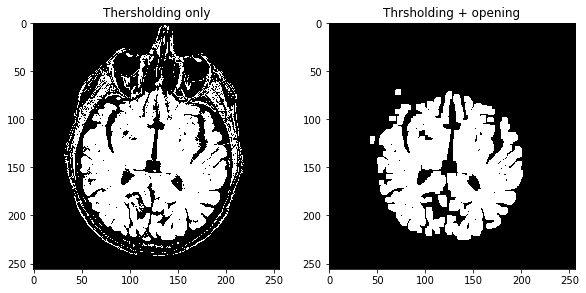

In [15]:
im_simp_tresh =simple_thresholding(brain_im,60,95) 
kernel = np.ones((5,5))
im_complex_tresh = cv2.morphologyEx(im_simp_tresh, cv2.MORPH_OPEN, kernel)
fig= plt.figure(figsize=((15,15)))
ax=fig.add_subplot(2,3,1)
ax.set_title("Thersholding only")
ax.imshow(im_simp_tresh,cmap='gray')

ax=fig.add_subplot(2,3,2)
ax.set_title("Thrsholding + opening")
ax.imshow(im_complex_tresh,cmap='gray')

print("The brain size using thresholding and opening is = ",im_complex_tresh.sum())

### Active contour

[0, 256, 256, 0]

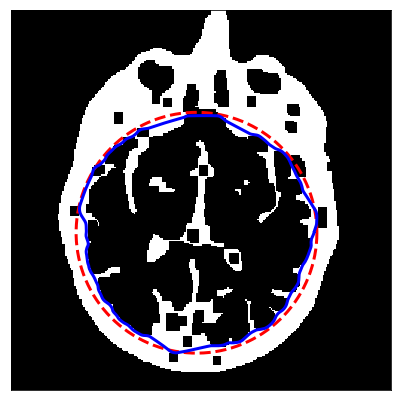

In [16]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.color import rgb2gray

img = rgb2gray((countour_closed))
s = np.linspace(0, 2*np.pi, 400)
x = 125 + 81*np.cos(s)
y = 150 + 81*np.sin(s)
init = np.array([x, y]).T

external_contour = active_contour(img,
                                  init, alpha=0.2, beta=0.01,w_edge=0.1,gamma=0.01)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(external_contour[:, 0], external_contour[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

Using the active contour we can detect the principal boundary of the brain (the cercle) , With this contour, we can create a filter : zerros outside the contour , and ones inside, by multiplying this new image with the original one we can see only the detected brain using the active contour, the result is depected bellow. 

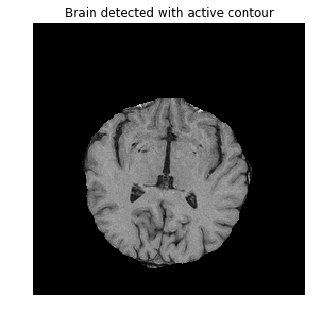

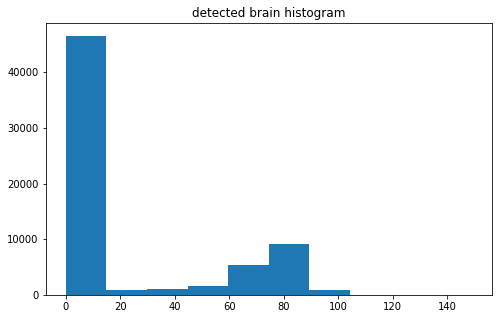

In [17]:
external_contour = external_contour.astype(int)
filter_= cv2.drawContours(np.zeros(brain_im.shape), [external_contour], 0, 1, -1)
detected_brain = brain_im * filter_

plt.figure(figsize=(8,5))
plt.title("Brain detected with active contour")
plt.imshow(detected_brain, cmap=plt.cm.gray)
plt.axis("off")
plt.figure(figsize=(8,5))
plt.hist(detected_brain.ravel())
plt.title("detected brain histogram")
plt.show()


Now , having the detected brain image , one can compute an approximation of the brain area using an histogram based threshold :threshold=60.

In [18]:
print("Brain size using active contour is ",sum(sum(detected_brain>60)))

Brain size using active contour is  15269


Thershold can provide an good approximation of the area of the brain, this is interesting because the comnputational cost of thershold is quite low. 
Active contours is performing well.

### PART1 Conclusion : 
Summarizing, we implemented different techniques of image segmentation to detect the brain of MRI image and then compute the area: 
* ***Two methods of region growing using two different conditions for labelling***  
* ***Two methods of contour detection*** 
* ***Simple thresholding*** 
* ***Active contour***.

In total we tested 6 different methods, more explanation are given above. We are pretty satisfied with our results. It's an interesting task of image segmentation based on a real world situation. It's good to see that the implemented method can approximately give us the brain size. 

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [19]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


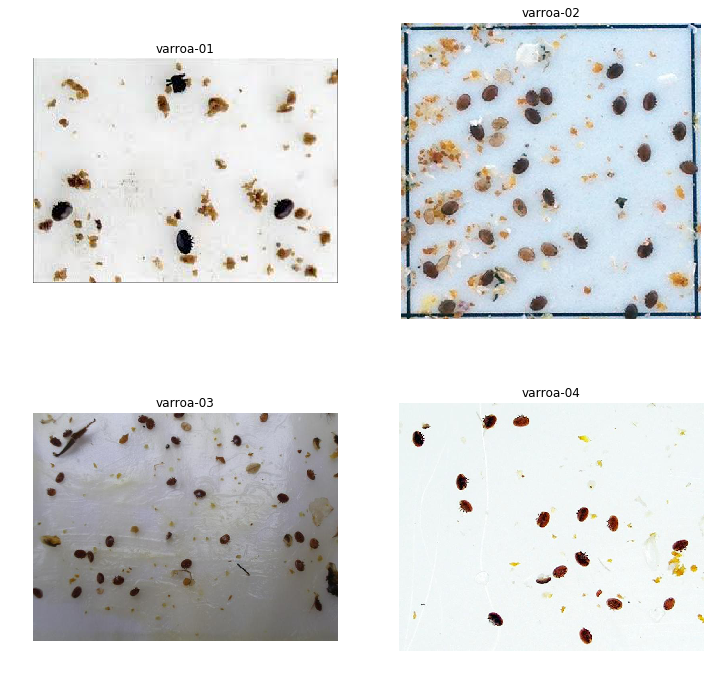

In [20]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [21]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [22]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]
annotations_xmls[0][2]['bbox']

[123, 153, 13, 11]

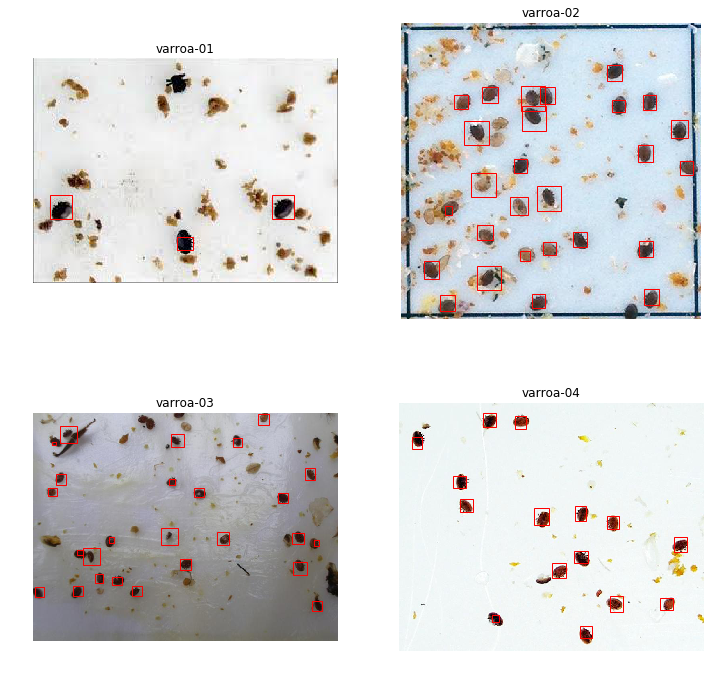

In [23]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

In this part of the lab we will identify the varroas on the different picture. To achive this goal the procedure used consist of:

* **Thresholding** First the images are thresholded so that a black and white matrix can be analysed.
* **Morphology** Then closing is performed to eliminated error in the image
* **Selection** Only the elements with an area suffinciently high are selected as varroas
* **Box** Boxes are drawn around the deteced varroas, by taking the lowest and highest x and y coordinates in the varroa

Once this procedure is applied to all images the $IoU$, Precision, Recall and $F_1$ can be calculated.

### Defintion of the different functions


Here some useful function are defined for later usage:

In [24]:
def image_tranform(image_file,threshold,kernel,morph_type="OPEN",plot="ON"):
    """"
    This function threshold the input image and do morphological opening or closing
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        image_file : string : The hole directory to the image file ex : '../data/lab-01-data/varroa-04.jpg'
        threshold: threshold value used to threshold the image 
        kernel: numpy array :  (square matrix) for morpholegical transformation (Opening or closing) 
                ex : kernel = np.ones((4,4))
        morph_type : string : Should be "OPEN" if you want opening or "CLOSE" if you want closing
        plot : string : default = "ON" : should be "ON" if you want to plot the image after thresholding and
                morphological transform
    -------------------------------------------------------------------------------------------------------
    return : 
        thresholded image as numpy array 
    """ 
    fig = plt.figure(figsize=(15,10))
    im = cv2.imread(image_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    if plot=="ON":
        ax=fig.add_subplot(2,3,1)
        ax.set_title("original image in grey")
        ax.imshow(im, cmap = 'gray')
    im[0:10,:]=255 
    im[:,0:10]=255
    im[-20:-1,:]=255
    im[:,-20:-1]=255
    ret,thresh = cv2.threshold(im,threshold,255,cv2.THRESH_BINARY)
    if plot=="ON":
        ax=fig.add_subplot(2,3,2)
        ax.set_title("Thresholded image")
        ax.imshow(thresh,cmap='gray')
        
    
    if morph_type=="OPEN":
        im = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel )
    elif morph_type=="CLOSE":
        im = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel )
    else:
        raise Exception('morph_type should be"OPEN" or "CLOSE"')

    if plot=="ON":
        ax=fig.add_subplot(2,3,3)
        ax.set_title("Image after opening")
        ax.imshow(im,cmap='gray')    
    return im

In [25]:
def find_countours_with_threshold(image,area_threshold,area_threshold_max=800):
    """"
    This function find the contours of an input image that satisfies a correponding area threshold 
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        image : numpy array : The input image 
        area_threshold: threshold area 
    -------------------------------------------------------------------------------------------------------
    return : (contour_list,contour_area)
        contour_list : a list of contours of the image that have an area above to the area_threshold
        contour_area : a list with the corresponding area of the different image contours
    """ 
    contours_detection = measure.find_contours(image,10)
    contours_list = []
    contour_area=[]
    for j,i in enumerate(contours_detection):
        if   (cv2.contourArea(contours_detection[j].astype(int))>area_threshold) and ((cv2.contourArea(contours_detection[j].astype(int))<=area_threshold_max)):
            contours_list.append(i)
            contour_area.append(cv2.contourArea(contours_detection[j].astype(int)))
    return(contours_list,contour_area) 
        

In [26]:
def create_box(arrayx,arrayy): 
    """"
    This function creates a rectangle a box arround the contour of an image
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        arrayx : list of x cordinates of the contour:  
        arrayy: list of y cordinates of the contour 
    -------------------------------------------------------------------------------------------------------
    return : (x,y,w,h)
        x: the x pixel of the top left point of the rectangle 
        y: the y pixel of the top left point of the rectangle
        w: width of the rectangle
        h: height of the rectangle
    """     
    x=min(arrayx)
    y=min(arrayy)
    w=max(arrayx)-x 
    h=max(arrayy)-y
    return [x.astype(int)-1,y.astype(int)-1,w.astype(int)+1,h.astype(int)+1]

def predicted_varroa(countours_list):
    """"
    This function returns the contours of the detected varroas as a list of rectangles 
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        contour_list : list of the different contours of the image 
    -------------------------------------------------------------------------------------------------------
    return : 
        list of the contours as rectangles : these rectangles corresponds to the predicted varroas
    """     
    varroa_box=[]
    for i in range(len(countours_list)): 
        box2=create_box(countours_list[i][:, 1],countours_list[i][:, 0])
        varroa_box.append(box2)
    return varroa_box

In [27]:
def plot_predictedVsGround(im,ground_truth,predicted_varroa):
    """"
    This function plot the ground_truth Vs predicted_Varroas as rectangles 
    
    Inputs
    -------------------------------------------------------------------------------------------------------
        im: numpy array of the image where to plot the rectangles : this can be the input original binary image 
        ground_truth : list of ground truth varroas rectangles 
        predicted_varroas : list of predicted_varroas rectangles
    -------------------------------------------------------------------------------------------------------
    return : 
       NONE
    """     

    fig,ax = plt.subplots(figsize=((7,7)))
    ax.set_title("Ground truth varroas vs predicted varroas")
    ax.imshow(im,cmap='gray')

    for i in range(len(predicted_varroa)):
        green_rect=patches.Rectangle((predicted_varroa[i][0],predicted_varroa[i][1]),predicted_varroa[i][2],predicted_varroa[i][3],facecolor='none',linewidth=1,edgecolor='g',label='Predicted varroas') 

        ax.add_patch(green_rect)
    for box in ground_truth: 
        red_rect = patches.Rectangle((box[0], box[1]), box[2], box[3],
                                 linewidth=1,edgecolor='r',facecolor='none',label='Ground trurh')
        ax.add_patch(red_rect)
        ax.legend(handles=[red_rect,green_rect])

#### Let's start with the first image 

Now we can apply the procedure specified above.
The varroa boxes in the form of $[x, y, w, l]$, where $x$ and $y$ are the coordinates of right uppermost corner and $w$ is the width of the box in pixels and $l$ is the length of the box in pixels, the total number of detected varroas is printed as well.

[[117, 14, 12, 15], [206, 121, 15, 16], [15, 123, 16, 15], [122, 148, 12, 18]]
The number of predicted varroas is:  4


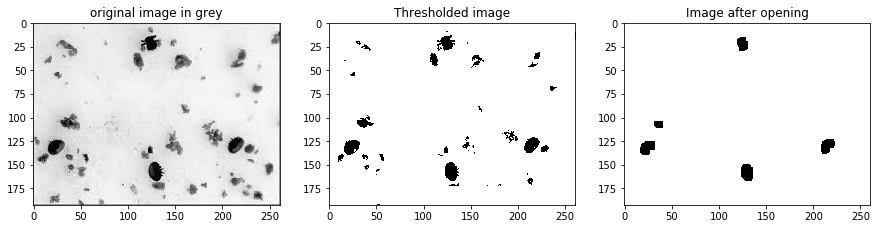

In [28]:
image_file='../data/lab-01-data/varroa-01.jpg'
kernelSize=6
kernel = np.ones((kernelSize,kernelSize))
im_1=image_tranform(image_file,100,kernel,"CLOSE","ON")
(contours_list_1,contour_area_1)=find_countours_with_threshold(im_1,100)
varroa_box_1=predicted_varroa(contours_list_1)
print(varroa_box_1)
print("The number of predicted varroas is: ",len(varroa_box_1))
ground_truth_1=[]
for i in range(len(annotations_xmls[0])): 
    ground_truth_1.append(annotations_xmls[0][i]['bbox'])

#### For visualisation purposes we will show the ground truth varroa boxes and the predicted varroa boxes


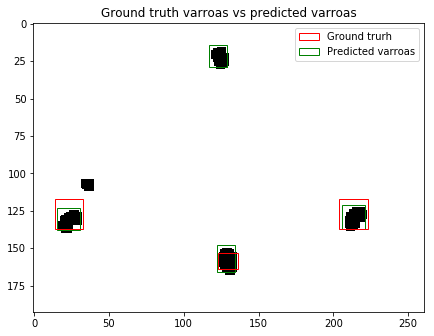

In [29]:
plot_predictedVsGround(im_1,ground_truth_1,varroa_box_1)

#### Second Image :  

[[294, 58, 24, 22], [115, 88, 22, 24], [178, 93, 38, 26], [347, 100, 18, 25], [78, 105, 20, 20], [304, 105, 19, 26], [176, 122, 23, 23], [390, 143, 19, 25], [98, 147, 20, 22], [339, 175, 19, 24], [40, 184, 21, 16], [159, 194, 23, 23], [202, 238, 17, 24], [163, 254, 16, 20], [46, 256, 34, 22], [110, 297, 22, 21], [246, 301, 20, 23], [339, 316, 22, 21], [203, 318, 20, 17], [169, 327, 15, 15], [30, 342, 22, 25], [112, 355, 20, 22], [350, 385, 18, 20], [186, 393, 22, 12]]
The number of predicted varroas is:  24


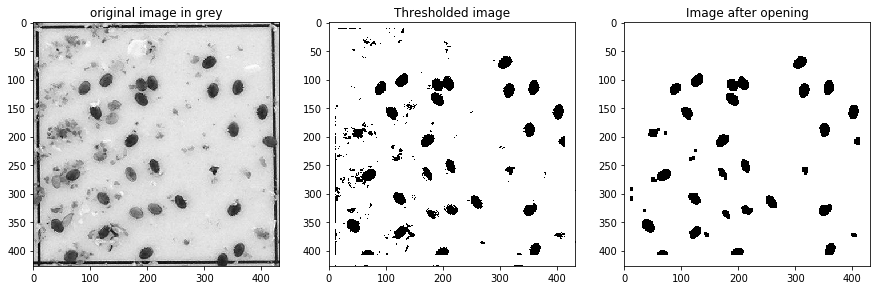

In [30]:
image_file='../data/lab-01-data/varroa-02.jpg'
kernelSize=5
kernel = np.ones((kernelSize,kernelSize))
im_2=image_tranform(image_file,135,kernel,"CLOSE","ON")
(contours_list_2,contour_area_2)=find_countours_with_threshold(im_2,130)
varroa_box_2=predicted_varroa(contours_list_2)
print(varroa_box_2)
print("The number of predicted varroas is: ",len(varroa_box_2))
ground_truth_2=[]
for i in range(len(annotations_xmls[1])): 
    ground_truth_2.append(annotations_xmls[1][i]['bbox'])

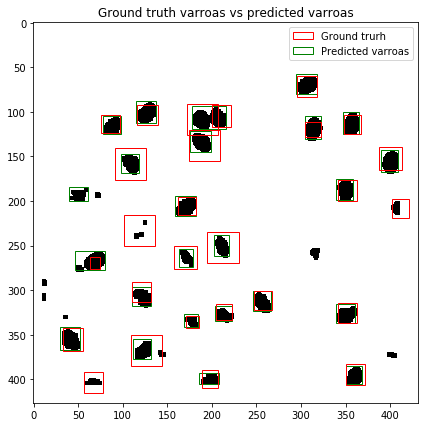

In [31]:
plot_predictedVsGround(im_2,ground_truth_2,varroa_box_2)

#### Third image : 

[[64, 38, 16, 14], [420, 49, 16, 21], [290, 52, 16, 15], [36, 54, 22, 17], [574, 120, 16, 20], [48, 126, 16, 20], [281, 139, 18, 14], [30, 161, 15, 14], [338, 162, 23, 16], [513, 170, 22, 19], [548, 250, 20, 23], [527, 255, 12, 17], [392, 256, 20, 19], [152, 259, 16, 23], [24, 265, 24, 16], [580, 265, 18, 21], [86, 288, 26, 18], [113, 292, 14, 21], [310, 308, 22, 19], [549, 309, 19, 24], [134, 337, 15, 21], [167, 343, 23, 19], [315, 348, 15, 14], [80, 365, 21, 24], [203, 368, 19, 17], [587, 385, 19, 32]]
The number of predicted varroas is:  26


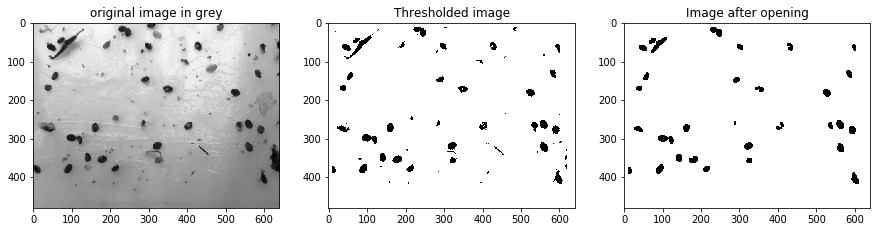

In [32]:
image_file='../data/lab-01-data/varroa-03.jpg'
kernelSize=6
kernel = np.ones((kernelSize,kernelSize))
im_3=image_tranform(image_file,80,kernel,"CLOSE","ON")
(contours_list_3,contour_area_3)=find_countours_with_threshold(im_3,160,500)
varroa_box_3=predicted_varroa(contours_list_3)
print(varroa_box_3)
print("The number of predicted varroas is: ",len(varroa_box_3))
ground_truth_3=[]
for i in range(len(annotations_xmls[2])): 
    ground_truth_3.append(annotations_xmls[2][i]['bbox'])

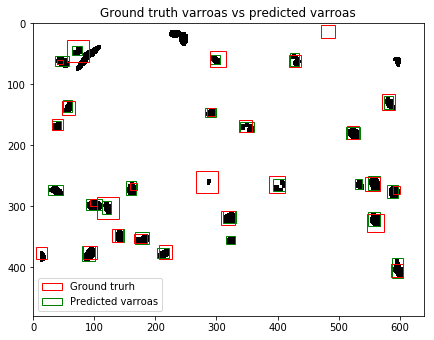

In [33]:
plot_predictedVsGround(im_3,ground_truth_3,varroa_box_3)

#### Fourth image

[[212, 33, 30, 32], [286, 37, 38, 22], [34, 73, 26, 37], [143, 181, 24, 37], [153, 246, 28, 27], [446, 263, 27, 34], [346, 275, 29, 37], [523, 285, 24, 34], [685, 344, 36, 25], [441, 376, 32, 33], [385, 409, 32, 28], [664, 491, 21, 27], [522, 492, 35, 25], [225, 525, 33, 33], [453, 567, 28, 34]]
The number of predicted varroas is:  15


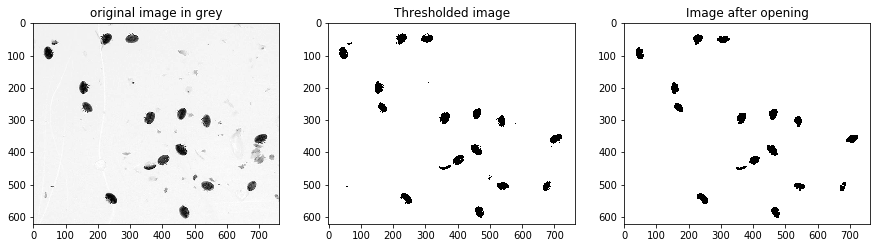

In [34]:
image_file='../data/lab-01-data/varroa-04.jpg'
kernelSize=6
kernel = np.ones((kernelSize,kernelSize))
im_4=image_tranform(image_file,110,kernel,"CLOSE","ON")
(contours_list_4,contour_area_4)=find_countours_with_threshold(im_4,300)
varroa_box_4=predicted_varroa(contours_list_4)
print(varroa_box_4)
print("The number of predicted varroas is: ",len(varroa_box_4))
ground_truth_4=[]
for i in range(len(annotations_xmls[3])): 
    ground_truth_4.append(annotations_xmls[3][i]['bbox'])

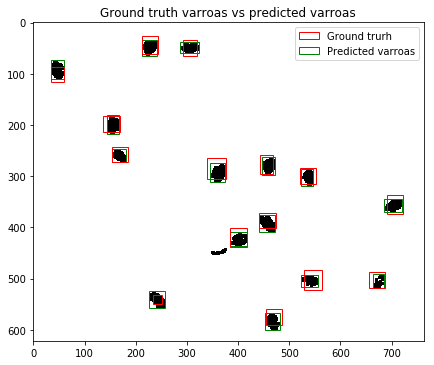

In [35]:
plot_predictedVsGround(im_4,ground_truth_4,varroa_box_4)

By analysing the images above it is possible to notice that for image 1 and 4 the predictad varroas are matching the ground truth very closely, while for image 2 and 3 the there is some mismacth.

### 2.3 IoU of the detected pattern w.r.t. the ground truth

In [36]:
def box_intersection_over_union(boxA, boxB):
    """"
    Given simply two boxes , this function computes the intersection over union.
    -------------------------------------------------------------------------------------------
    
    Inputs :
        boxA: list : [x,y,width,height] where x,y are the postion of 
        the first point of the rectangle (top left).
        
        boxB: list : [x,y,width,height] where x,y are the postion of 
        the first point of the rectangle (top left).
        
    ------------------------------------------------------------------------------------------------------
    Return : 
        iou: float number : the intersection over union of the two boxes
    """
    
    #determine the (x, y)-coordinates of the intersection rectangle
    boxA=[boxA[0],boxA[1],boxA[0]+boxA[2],boxA[1]+boxA[3]]
    boxB=[boxB[0],boxB[1],boxB[0]+boxB[2],boxB[1]+boxB[3]]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [37]:
def compute_iou(ground_truth,predicted_varroa):
    """
    This function computes the intersection over union using boxes.
    -------------------------------------------------------------------------------------------
    
    Inputs :
        ground_truth: ground truth boxes :Type: list : each list contains [x,y,width,height] 
        where x,y are the postion of the first point of the rectangle (top left).
        
        predicted_varroa: predicted varroas boxes :Type: list : each list contains [x,y,width,height] 
        where x,y are the postion of the first point of the box (top left).
        
        
    ------------------------------------------------------------------------------------------------------
    Return : 
        iou: numpy array : size[number of ground_truth varroas,number of predicted varroas]: This variable 
        should contain the compted intersection over union of each ground truth box and all the predicted 
        varroas boxes.
    """ 
    iou=-1*np.zeros((len(ground_truth),len(predicted_varroa)))
    for i in range(len(ground_truth)): 
        for j in range(len(predicted_varroa)):
            iou[i,j]=box_intersection_over_union(ground_truth[i],predicted_varroa[j])
   
    return iou

In [38]:
iou1=compute_iou(ground_truth_1,varroa_box_1)
iou2=compute_iou(ground_truth_2,varroa_box_2)
iou3=compute_iou(ground_truth_3,varroa_box_3)
iou4=compute_iou(ground_truth_4,varroa_box_4)

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Here we will compute the $IoU$ and the $F_1$ by comparing the ground truth and the images obtained by different thershold values.

In [39]:
def compute_confusion_matrix(ground_truth,iou,threshold_iou):
    """
    This function computes the True positive , False negative and False postive of the confusion matrix 
    --------------------------------------------------------------------------------------------------
    
    Inputs :
        ground_truth: ground truth boxes :Type: list : each list contains [x,y,width,height] 
        where x,y are the postion of the first point of the rectangle (top left).
        
        iou: numpy array : size[number of ground_truth varroas,number of predicted varroas]: This variable 
        should contain the compted intersection over union of each ground truth box and all the predicted 
        varroas boxes.
        
        threshold_iou : float : threshold selected to compute the True postives.
    ------------------------------------------------------------------------------------------------------
    Return : 
        (TP,FP,FN) : True postive , false postive and false negative.  
    """ 
    iou_groundVspred=np.sort(iou)
    iou_predVsground=np.sort(iou.transpose())
    iou_groundVspred=iou_groundVspred[:,-1]
    iou_predVsground=iou_predVsground[:,-1]
    
    TP=iou_groundVspred[iou_groundVspred>threshold_iou].shape[0]
    FN=len(ground_truth)-TP 
    FP=np.count_nonzero(iou_predVsground==0)
    return (TP,FP,FN)
def compute_precsion_recall_fmeasure(TP,FN,FP):
    """
    This function computes recall , precision and f_measure. 
    --------------------------------------------------------------------------------------------------
    
    Inputs :
        TP: int : True postive
        FN: int : False negative
        FP : int : False postive
    ------------------------------------------------------------------------------------------------------
    Return : 
        (precision,recall,f_measure) : precision , recall and f_measure. 
    """ 
    
    if TP==0: 
        return (0,0,0)
    precision=TP/(TP+FN)
    recall=TP/(TP+FP)
    
    f_measure=2*precision*recall/(precision+recall)
    return (precision,recall,f_measure)

In [40]:
(TP1,FP1,FN1)=compute_confusion_matrix(ground_truth_1,iou1,0.5)
(precision1,recall1,f_measure1)=compute_precsion_recall_fmeasure(TP1,FN1,FP1)
(TP1,FP1,FN1)=compute_confusion_matrix(ground_truth_1,iou1,0.9)
(precision1_09,recall1_09,f_measure1_09)=compute_precsion_recall_fmeasure(TP1,FN1,FP1)
print("(Precision, Recall) with threshold 0.5   = ",(precision1,recall1))
print("F_measure for image 1 with threshold 0.5 = ",f_measure1)
print("(Precision, Recall) with threshold 0.9   = ",(precision1_09,recall1_09))
print("F_measure for image 1 with threshold 0.9 = ",f_measure1_09)

(Precision, Recall) with threshold 0.5   =  (1.0, 0.75)
F_measure for image 1 with threshold 0.5 =  0.8571428571428571
(Precision, Recall) with threshold 0.9   =  (0, 0)
F_measure for image 1 with threshold 0.9 =  0


In [41]:
(TP2,FP2,FN2)=compute_confusion_matrix(ground_truth_2,iou2,0.5)
(precision2,recall2,f_measure2)=compute_precsion_recall_fmeasure(TP2,FN2,FP2)
(TP2,FP2,FN2)=compute_confusion_matrix(ground_truth_2,iou2,0.9)
(precision2_09,recall2_09,f_measure2_09)=compute_precsion_recall_fmeasure(TP2,FN2,FP2)
print("(Precision, Recall) with threshold 0.5   = ",(precision2,recall2))
print("F_measure for image 2 with threshold 0.5 = ",f_measure2)
print("(Precision, Recall) with threshold 0.9   = ",(precision2_09,recall2_09))
print("F_measure for image 2 with threshold 0.9 = ",f_measure2_09)

(Precision, Recall) with threshold 0.5   =  (0.6666666666666666, 0.9473684210526315)
F_measure for image 2 with threshold 0.5 =  0.782608695652174
(Precision, Recall) with threshold 0.9   =  (0, 0)
F_measure for image 2 with threshold 0.9 =  0


In [42]:
(TP3,FP3,FN3)=compute_confusion_matrix(ground_truth_3,iou3,0.5)
(precision3,recall3,f_measure3)=compute_precsion_recall_fmeasure(TP3,FN3,FP3)
(TP3,FP3,FN3)=compute_confusion_matrix(ground_truth_3,iou3,0.9)
(precision3_09,recall3_09,f_measure3_09)=compute_precsion_recall_fmeasure(TP3,FN3,FP3)
print("(Precision, Recall) with threshold 0.5   = ",(precision3,recall3))
print("F_measure for image 3 with threshold 0.5 = ",f_measure3)
print("(Precision, Recall) with threshold 0.9   = ",(precision3_09,recall3_09))
print("F_measure for image 3 with threshold 0.9 = ",f_measure3_09)

(Precision, Recall) with threshold 0.5   =  (0.5769230769230769, 0.8333333333333334)
F_measure for image 3 with threshold 0.5 =  0.6818181818181818
(Precision, Recall) with threshold 0.9   =  (0, 0)
F_measure for image 3 with threshold 0.9 =  0


In [43]:
(TP4,FP4,FN4)=compute_confusion_matrix(ground_truth_4,iou4,0.5)
(precision4,recall4,f_measure4)=compute_precsion_recall_fmeasure(TP4,FN4,FP4)
(TP4,FP4,FN4)=compute_confusion_matrix(ground_truth_4,iou4,0.9)
(precision4_09,recall4_09,f_measure4_09)=compute_precsion_recall_fmeasure(TP4,FN4,FP4)
print("(Precision, Recall) with threshold 0.5   = ",(precision4,recall4))
print("F_measure for image 4 with threshold 0.5 = ",f_measure4)
print("(Precision, Recall) with threshold 0.9   = ",(precision4_09,recall4_09))
print("F_measure for image 4 with threshold 0.9 = ",f_measure4_09)

(Precision, Recall) with threshold 0.5   =  (0.8, 1.0)
F_measure for image 4 with threshold 0.5 =  0.888888888888889
(Precision, Recall) with threshold 0.9   =  (0, 0)
F_measure for image 4 with threshold 0.9 =  0


## Conclusion

To compute the $F_1$ value the varroas are considered as detected if the $IoU$ of the varroa is bigger than a given threshold. Two values are used: 0.5 and 0.9. The second one being very strict.
As expexted the $F_1$ for images 1 and 4 with threshold of 0.5 is higher than for images 2 and 3. With a threshold of 0.9 no varroas are deteced so the $F_1$ is zero.  
It is possible to say that even if a quite easy algorithm is implemented to treat the images, the results are impressive. On the other hand is important to notice that the parameters for image analysis are tuned for each image to obtain the best results. 